In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.patches import Patch
from utils import time_string_to_seconds
path = os.getcwd()
res_path = path

In [2]:
experiment_name = 'hetero'

In [3]:
# Make folder for experiment if it doesn't exist
experiment_path = os.path.join(res_path, 'plots', experiment_name)
if not os.path.exists(os.path.join(res_path, 'plots')):
    os.mkdir(os.path.join(res_path, 'plots'))
if not os.path.exists(experiment_path):
    os.mkdir(experiment_path)

In [4]:
last_day = 244
df_sup = pd.read_csv(r'../results/sp-repl_id-0/day_{}_drivers.csv'.format(last_day))
df_dem = pd.read_csv(r'../results/sp-repl_id-0/day_{}_travs.csv'.format(last_day))
veh = pd.read_csv(r'../results/sp-repl_id-0/2_driver-properties.csv')
pax = pd.read_csv(r'../results/sp-repl_id-0/1_pax-properties.csv')
df_sup = df_sup.set_index('veh')
veh = veh.set_index('Unnamed: 0')
pax = pax.set_index('Unnamed: 0')

In [5]:
# df_dem.ttrav_0

In [6]:
df_sup['ptcp_0'] = df_sup.apply(lambda x: 1 if not x['out_0'] else np.nan, axis=1)
df_sup['ptcp_1'] = df_sup.apply(lambda x: 1 if not x['out_1'] else np.nan, axis=1)
df_sup['exp_inc_0'] = df_sup['exp_inc'] * df_sup['ptcp_0']
df_sup['exp_inc_1'] = df_sup['exp_inc'] * df_sup['ptcp_1']

In [7]:
df_dem['VoT'] = pax['VoT'].copy()
df_dem['dist'] = pax['dist'].copy()
df_dem['ttrav'] = pax.apply(lambda row: time_string_to_seconds(row['ttrav']), axis=1).copy()
df_dem['xp_detour_0'] = df_dem['xp_ivt_0'] - df_dem['ttrav']
df_dem['xp_detour_1'] = df_dem['xp_ivt_1'] - df_dem['ttrav']
df_dem['ttrav_0'] = df_dem.apply(lambda row: row['ttrav'] if row['requests_0'] else np.nan, axis=1)
df_dem['ttrav_1'] = df_dem.apply(lambda row: row['ttrav'] if row['requests_1'] else np.nan, axis=1)
df_dem['dist_0'] = df_dem.apply(lambda row: row['dist'] if row['requests_0'] else np.nan, axis=1)
df_dem['dist_1'] = df_dem.apply(lambda row: row['dist'] if row['requests_1'] else np.nan, axis=1)

In [8]:
# Convert seconds to min
time_indicators = [['xp_wait_0', 'xp_wait_1', 'xp_ivt_0', 'xp_ivt_1', 'ttrav_0', 'ttrav_1', 'xp_detour_0', 'xp_detour_1']]
for time_indic in time_indicators:
    df_dem[time_indic] = df_dem[time_indic] / 60

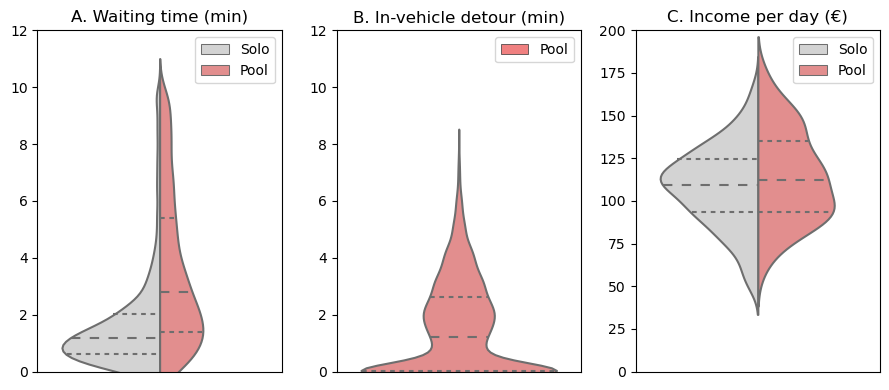

In [9]:
# Combine relevant columns
df_combined = pd.concat([
    df_dem[['xp_wait_0', 'xp_wait_1']],
    df_dem[['xp_detour_0', 'xp_detour_1']],
    df_sup[['exp_inc_0', 'exp_inc_1']]
], axis=1)

# Melt the dataframe to long format
df_melted = df_combined.melt(var_name='Metric', value_name='Value')

# Extract base metric names and categories (e.g., _0, _1)
df_melted['Base Metric'] = df_melted['Metric'].str.extract(r'(xp_wait|xp_detour|exp_inc)')
df_melted['Platform'] = df_melted['Metric'].str.extract(r'(0|1)').astype(str)

# Map the Platform values to custom legend labels
Platform_mapping = {'0': 'Solo', '1': 'Pool'}
df_melted['Platform'] = df_melted['Platform'].map(Platform_mapping)

# Plot violin plots
fig, axes = plt.subplots(1, 3, figsize=(9, 4))

# List of base metrics and their titles
base_metrics = ['xp_wait', 'xp_detour', 'exp_inc']
titles = ['A. Waiting time (min)', 'B. In-vehicle detour (min)', 'C. Income per day (\u20ac)']

# Define colors for the categories
colors = {'Solo': 'lightgrey', 'Pool': 'lightcoral'}

for i, base_metric in enumerate(base_metrics):
    # cut_value = 0 if base_metric == 'xp_wait' else 2
    if base_metric == 'xp_detour':
        sns.violinplot(ax=axes[i], y='xp_detour_1', data=df_dem, inner="quart",color='lightcoral')
        handles = [Patch(facecolor='lightcoral', edgecolor='#333333', linewidth=0.5)]
        labels = ['Pool']
        axes[i].legend(handles, labels)
    else:
        sns.violinplot(ax=axes[i], x='Base Metric', y='Value', hue='Platform', data=df_melted[df_melted['Base Metric'] == base_metric], split=True, inner="quart", palette=colors)
        axes[i].legend(title="")
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].set_xticks([])  # Optionally remove x-axis ticks if needed
    # Customize legend
    axes[i].set_ylim([0, None])

axes[0].set_ylim([0, 12])
axes[1].set_ylim([0, 12])
axes[2].set_ylim([0, 200])
# Set common labels
# fig.text(0.5, 0.04, 'Category', ha='center')
# fig.text(0.04, 0.5, 'Value', va='center', rotation='vertical')

plt.tight_layout()
plt.savefig(os.path.join(experiment_path,'distr-kpis.png'), facecolor='w', dpi=400)
plt.show()

In [10]:
# Participation based on VoT
# Demand: mode choice depending on VoT --> quartiles
# Supply: "e.g. quartiles --> registered and participating"


In [11]:
df_sup['res_wage'] = veh['res_wage'].copy()
df_melted

,Metric,Value,Base Metric,Platform
0,xp_wait_0,0.719833,xp_wait,Solo
1,xp_wait_0,NaN,xp_wait,Solo
2,xp_wait_0,0.486667,xp_wait,Solo
3,xp_wait_0,0.803000,xp_wait,Solo
4,xp_wait_0,NaN,xp_wait,Solo
...,...,...,...,...
185539,exp_inc_1,NaN,exp_inc,Pool
185540,exp_inc_1,NaN,exp_inc,Pool
185541,exp_inc_1,NaN,exp_inc,Pool
185542,exp_inc_1,NaN,exp_inc,Pool


In [12]:
veh.keys()

Index(['pos', 'res_wage', 'multihoming'], dtype='object')

In [13]:
df_sup[['expected_income_0','expected_income_1']].mean()

expected_income_0    110.133230
expected_income_1    108.198697
dtype: float64

In [14]:
# # Define labels for 20 quantile bins, each representing a 5% interval
# labels = [
#     'P0-P5', 'P5-P10', 'P10-P15', 'P15-P20', 'P20-P25',
#     'P25-P30', 'P30-P35', 'P35-P40', 'P40-P45', 'P45-P50',
#     'P50-P55', 'P55-P60', 'P60-P65', 'P65-P70', 'P70-P75',
#     'P75-P80', 'P80-P85', 'P85-P90', 'P90-P95', 'P95-P100'
# ]
# # Apply pd.qcut to create 20 quantile-based bins with specified labels
# df_sup['RW_group'] = pd.qcut(df_sup['res_wage'], q=20, labels=labels)
df_sup['RW_group'] = pd.qcut(df_sup['res_wage'], q=10, labels=['P0-10', 'P10-20', 'P20-30', 'P30-40', 'P40-50','P50-60', 'P60-70', 'P70-80', 'P80-90', 'P90-100'])
# Specify the categories you want to display
categories_to_show = ['P0-10', 'P10-20', 'P20-30', 'P30-40']

df_dem['VoT_group'] = pd.qcut(df_dem['VoT'], q=10, labels=['P0-10', 'P10-20', 'P20-30', 'P30-40', 'P40-50','P50-60', 'P60-70', 'P70-80', 'P80-90', 'P90-100'])
categories_to_show_dem = ['P0-10', 'P10-20', 'P20-30', 'P30-40','P40-50','P50-60', 'P60-70', 'P70-80', 'P80-90', 'P90-100']

df_dem['dist_group'] = pd.qcut(df_dem['dist'], q=10, labels=['P0-10', 'P10-20', 'P20-30', 'P30-40', 'P40-50','P50-60', 'P60-70', 'P70-80', 'P80-90', 'P90-100'])

c:\Users\ge27fus\.conda\envs\fleetmaas_eval\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


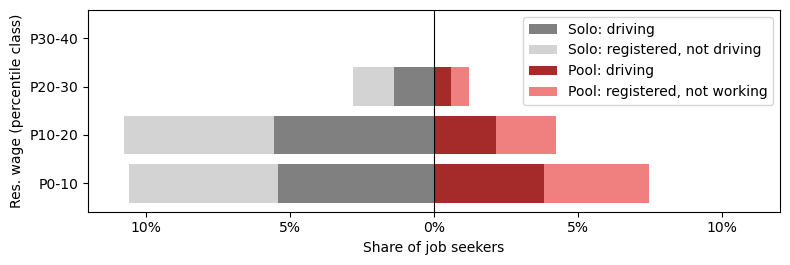

In [15]:
# Create new columns based on the conditions
df_sup['reg_no_ptcp_0'] = df_sup.apply(lambda row: row['registered_0'] * row['ptcp_0'], axis=1)
df_sup['reg_no_ptcp_1'] = df_sup.apply(lambda row: row['registered_1'] * row['ptcp_1'], axis=1)

df_filtered = df_sup[df_sup['RW_group'].isin(categories_to_show)]
# Reorder categories in the filtered DataFrame if needed
df_filtered['RW_group'] = pd.Categorical(df_filtered['RW_group'], categories=categories_to_show, ordered=True)
# Group by 'RW_group' and sum the counts of True values for each column
grouped_df = df_filtered.groupby('RW_group').sum().reset_index()

# Calculate the total number of rows in the dataframe
total_rows = len(df_sup)

# Calculate the percentage for each column
grouped_df['ptcp_0_pct'] = grouped_df['ptcp_0'] / total_rows * 100
grouped_df['reg_no_ptcp_0_pct'] = grouped_df['reg_no_ptcp_0'] / total_rows * 100
grouped_df['ptcp_1_pct'] = grouped_df['ptcp_1'] / total_rows * 100
grouped_df['reg_no_ptcp_1_pct'] = grouped_df['reg_no_ptcp_1'] / total_rows * 100

# Plotting
fig, ax = plt.subplots(figsize=(8, 2.75))

# Positive values (stacked horizontally)
ax.barh(grouped_df['RW_group'], -grouped_df['ptcp_0_pct'], color='grey', label='ptcp_0 (positive)')
ax.barh(grouped_df['RW_group'], -grouped_df['reg_no_ptcp_0_pct'], color='lightgrey', label='reg_no_ptcp_0 (positive)', left=-grouped_df['ptcp_0_pct'])

# Negative values (stacked horizontally, in negative space)
ax.barh(grouped_df['RW_group'], grouped_df['ptcp_1_pct'], color='brown', label='ptcp_1 (negative)')
ax.barh(grouped_df['RW_group'], grouped_df['reg_no_ptcp_1_pct'], color='lightcoral', label='reg_no_ptcp_1 (negative)', left=grouped_df['ptcp_1_pct'])

# Adding labels and title
ax.set_xlabel('Share of job seekers')
ax.set_ylabel('Res. wage (percentile class)')
# ax.set_title('Registered drivers with platforms in solo-pool market depending on drivers reservation wage')

# Adding a vertical line at x=0 for clarity
ax.axvline(0, color='black', linewidth=0.8)

# Custom formatter function to display positive values for negative ticks
def positive_ticks(x, pos):
    return '{:.0f}%'.format(abs(x))

# Apply the custom formatter to the y-axis
ax.xaxis.set_major_formatter(plt.FuncFormatter(positive_ticks))
ax.set_xlim([-12,12])

# Create custom legend handles and labels
handles, labels = ax.get_legend_handles_labels()
# bar_handles = handles  # Assuming bars are the first 4 handles
# bar_handles = [handles[2], handles[3], handles[0], handles[1]]
ax.legend(handles=handles, loc='best',labels=['Solo: driving','Solo: registered, not driving','Pool: driving','Pool: registered, not working'],fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(experiment_path,'distr-res-wage.png'), facecolor='w', dpi=400)
plt.show()

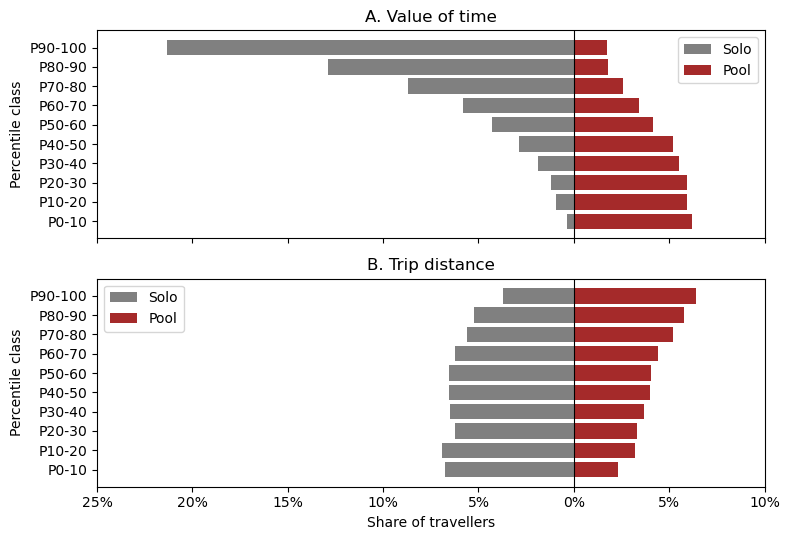

In [32]:
df_filtered = df_dem[df_dem['VoT_group'].isin(categories_to_show_dem)]
# Reorder categories in the filtered DataFrame if needed
df_filtered['VoT_group'] = pd.Categorical(df_filtered['VoT_group'], categories=categories_to_show_dem, ordered=True)
# Group by 'RW_group' and sum the counts of True values for each column
grouped_df = df_filtered.groupby('VoT_group').sum().reset_index()

# Calculate the total number of rows in the dataframe
total_rows = 100000 / 10 #len(df_dem)

# Calculate the percentage for each column
grouped_df['ptcp_0_pct'] = grouped_df['requests_0'] / total_rows * 100
grouped_df['ptcp_1_pct'] = grouped_df['requests_1'] / total_rows * 100

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(8, 5.5), sharex=True)

# Positive values (stacked horizontally)
axes[0].barh(grouped_df['VoT_group'], -grouped_df['ptcp_0_pct'], color='grey', label='ptcp_0 (positive)')

# Negative values (stacked horizontally, in negative space)
axes[0].barh(grouped_df['VoT_group'], grouped_df['ptcp_1_pct'], color='brown', label='ptcp_1 (negative)')

# Adding labels and title
# axes[0].set_xlabel('Share of travellers')
axes[0].set_ylabel('Percentile class')
# ax.set_title('Registered drivers with platforms in solo-pool market depending on drivers reservation wage')

# Adding a vertical line at x=0 for clarity
axes[0].axvline(0, color='black', linewidth=0.8)

# Custom formatter function to display positive values for negative ticks
def positive_ticks(x, pos):
    return '{:.0f}%'.format(abs(x))

# Apply the custom formatter to the y-axis
axes[0].xaxis.set_major_formatter(plt.FuncFormatter(positive_ticks))
axes[0].set_xlim([-25,10])
axes[0].set_title('A. Value of time')

# Create custom legend handles and labels
handles, labels = axes[0].get_legend_handles_labels()
# bar_handles = handles  # Assuming bars are the first 4 handles
# bar_handles = [handles[2], handles[3], handles[0], handles[1]]
axes[0].legend(handles=handles, loc='best',labels=['Solo','Pool'])

######

df_filtered = df_dem[df_dem['dist_group'].isin(categories_to_show_dem)]
# Reorder categories in the filtered DataFrame if needed
df_filtered['dist_group'] = pd.Categorical(df_filtered['dist_group'], categories=categories_to_show_dem, ordered=True)
# Group by 'RW_group' and sum the counts of True values for each column
grouped_df = df_filtered.groupby('dist_group').sum().reset_index()

# Calculate the total number of rows in the dataframe
total_rows = 100000 / 10 #len(df_dem)

# Calculate the percentage for each column
grouped_df['ptcp_0_pct'] = grouped_df['requests_0'] / total_rows * 100
grouped_df['ptcp_1_pct'] = grouped_df['requests_1'] / total_rows * 100

# Positive values (stacked horizontally)
axes[1].barh(grouped_df['dist_group'], -grouped_df['ptcp_0_pct'], color='grey', label='ptcp_0 (positive)')

# Negative values (stacked horizontally, in negative space)
axes[1].barh(grouped_df['dist_group'], grouped_df['ptcp_1_pct'], color='brown', label='ptcp_1 (negative)')

# Adding labels and title
axes[1].set_xlabel('Share of travellers')
axes[1].set_ylabel('Percentile class')
# ax.set_title('Registered drivers with platforms in solo-pool market depending on drivers reservation wage')

# Adding a vertical line at x=0 for clarity
axes[1].axvline(0, color='black', linewidth=0.8)

# Custom formatter function to display positive values for negative ticks
def positive_ticks(x, pos):
    return '{:.0f}%'.format(abs(x))

# Apply the custom formatter to the y-axis
axes[1].xaxis.set_major_formatter(plt.FuncFormatter(positive_ticks))
axes[1].tick_params(axis='y', labelsize=10)
axes[1].set_title('B. Trip distance')
# axes[1].set_xlim([-3,3])

# Create custom legend handles and labels
handles, labels = axes[1].get_legend_handles_labels()
# bar_handles = handles  # Assuming bars are the first 4 handles
# bar_handles = [handles[2], handles[3], handles[0], handles[1]]
axes[1].legend(handles=handles, loc='best',labels=['Solo','Pool'])

plt.tight_layout()
plt.savefig(os.path.join(experiment_path,'distr-VoT-dist.png'), facecolor='w', dpi=400)
plt.show()

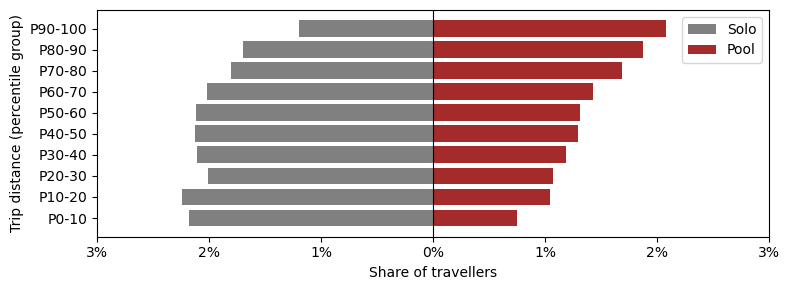

In [17]:
df_filtered = df_dem[df_dem['dist_group'].isin(categories_to_show_dem)]
# Reorder categories in the filtered DataFrame if needed
df_filtered['dist_group'] = pd.Categorical(df_filtered['dist_group'], categories=categories_to_show_dem, ordered=True)
# Group by 'RW_group' and sum the counts of True values for each column
grouped_df = df_filtered.groupby('dist_group').sum().reset_index()

# Calculate the total number of rows in the dataframe
total_rows = len(df_dem)

# Calculate the percentage for each column
grouped_df['ptcp_0_pct'] = grouped_df['requests_0'] / total_rows * 100
grouped_df['ptcp_1_pct'] = grouped_df['requests_1'] / total_rows * 100

# Plotting
fig, ax = plt.subplots(figsize=(8, 3))

# Positive values (stacked horizontally)
ax.barh(grouped_df['dist_group'], -grouped_df['ptcp_0_pct'], color='grey', label='ptcp_0 (positive)')

# Negative values (stacked horizontally, in negative space)
ax.barh(grouped_df['dist_group'], grouped_df['ptcp_1_pct'], color='brown', label='ptcp_1 (negative)')

# Adding labels and title
ax.set_xlabel('Share of travellers')
ax.set_ylabel('Trip distance (percentile group)')
# ax.set_title('Registered drivers with platforms in solo-pool market depending on drivers reservation wage')

# Adding a vertical line at x=0 for clarity
ax.axvline(0, color='black', linewidth=0.8)

# Custom formatter function to display positive values for negative ticks
def positive_ticks(x, pos):
    return '{:.0f}%'.format(abs(x))

# Apply the custom formatter to the y-axis
ax.xaxis.set_major_formatter(plt.FuncFormatter(positive_ticks))
ax.set_xlim([-3,3])

# Create custom legend handles and labels
handles, labels = ax.get_legend_handles_labels()
# bar_handles = handles  # Assuming bars are the first 4 handles
# bar_handles = [handles[2], handles[3], handles[0], handles[1]]
ax.legend(handles=handles, loc='best',labels=['Solo','Pool'])

plt.tight_layout()
plt.savefig(os.path.join(experiment_path,'distr-VoT.png'), facecolor='w', dpi=400)
plt.show()